# Calibration of the Chaboche mecanical model with bayesian methods

## Generate the observations

In [1]:
import numpy as np
import openturns as ot
import openturns.viewer as otv

Define the model.

In [2]:
def modelChaboche(X):
    strain, R, C, gamma = X
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche)
g.setInputDescription(["Strain", "R", "C", "Gamma"])
g.setOutputDescription(["Stress"])

Define the random vector.

In [4]:
Strain = ot.Uniform(0, 0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10.0
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Stress] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

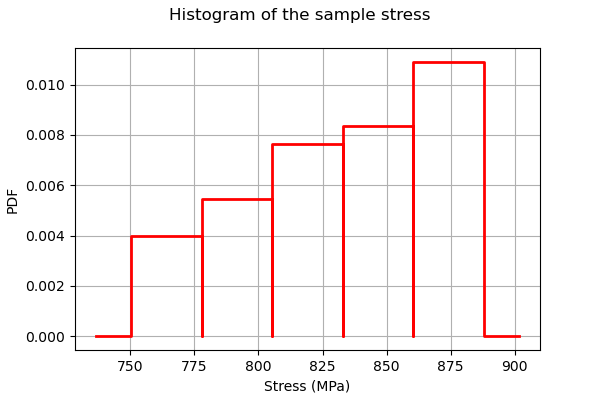

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress / 1.0e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 10.0e6  # (Pa)
noiseSigma = ot.Normal(0.0, stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [9]:
observedStrain = inputSample[:, 0]

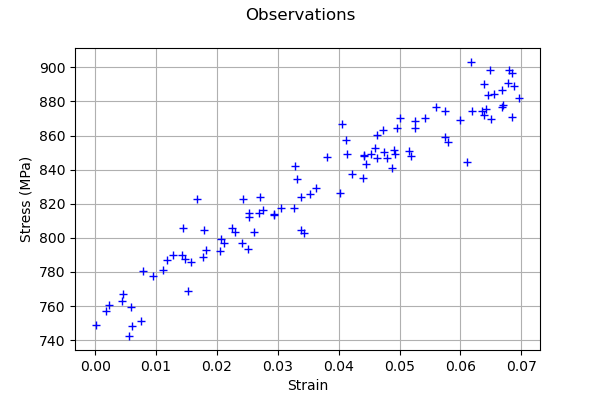

In [10]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress / 1.0e6)
graph.add(cloud)
graph

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [11]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

In [12]:
calibratedIndices = [1, 2, 3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Gaussian calibration parameters

The standard deviation of the observations errors.

In [13]:
sigmaStress = 1.0e7  # (Pa)

Define the covariance matrix of the output Y of the model.

In [14]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = sigmaStress ** 2

Define the covariance matrix of the parameters $\theta$ to calibrate.

In [15]:
sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

In [16]:
sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = sigmaR ** 2
sigma[1, 1] = sigmaC ** 2
sigma[2, 2] = sigmaGamma ** 2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4.9e+15,0,0,0,6.25e+16,0,0,0,0.64]

## Gaussian linear calibration

The `GaussianLinearCalibration` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [17]:
algo = ot.GaussianLinearCalibration(
    mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
)

The `run` method computes the solution of the problem.

In [18]:
algo.run()

In [19]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [20]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.49845e+08,2.60366e+09,8.15841]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [21]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.44583e+08,2.40769e+09,6.45772] upper bound=class=Point name=Unnamed dimension=3 values=[7.55108e+08,2.79962e+09,9.8591] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that the $R$ parameter (the first one) has a relalively small confidence interval. By contrast, the $\gamma$ parameter (the third one) is estimated with a large confidence interval.

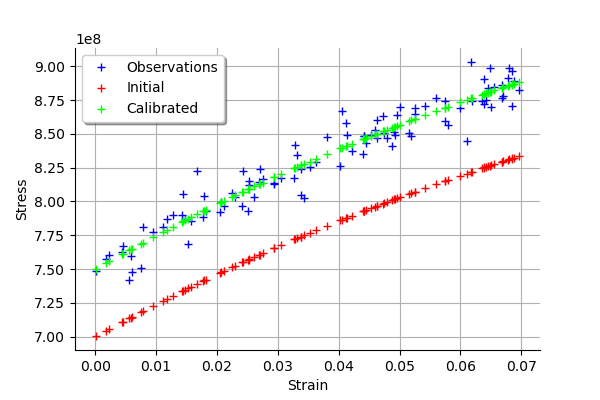

In [22]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

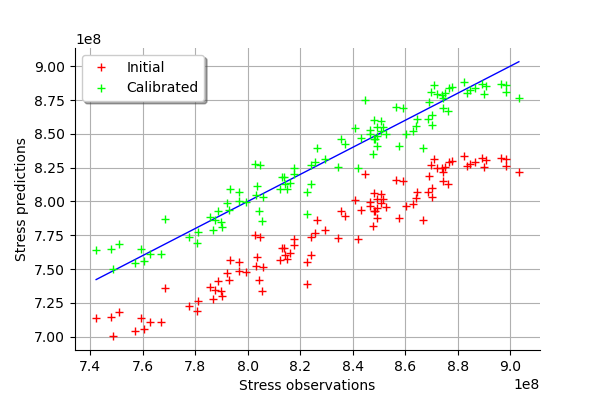

In [23]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by linearizing the problem at the prior. 

In [24]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

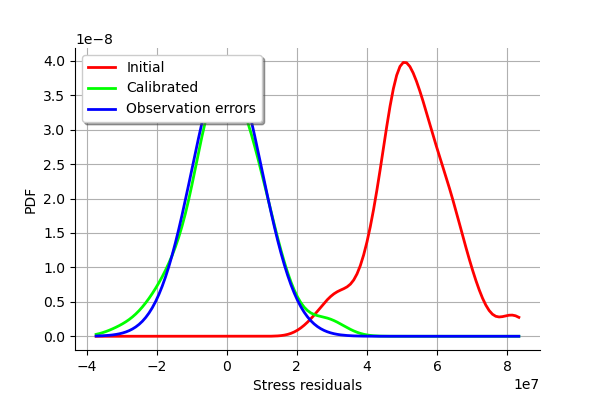

In [25]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the distribution of the residuals (the blue line) shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being gaussian.

The observation error distribution (in green) is much narrower than the actual residuals distribution. This shows that the prior observations error underestimated the actual error distribution.

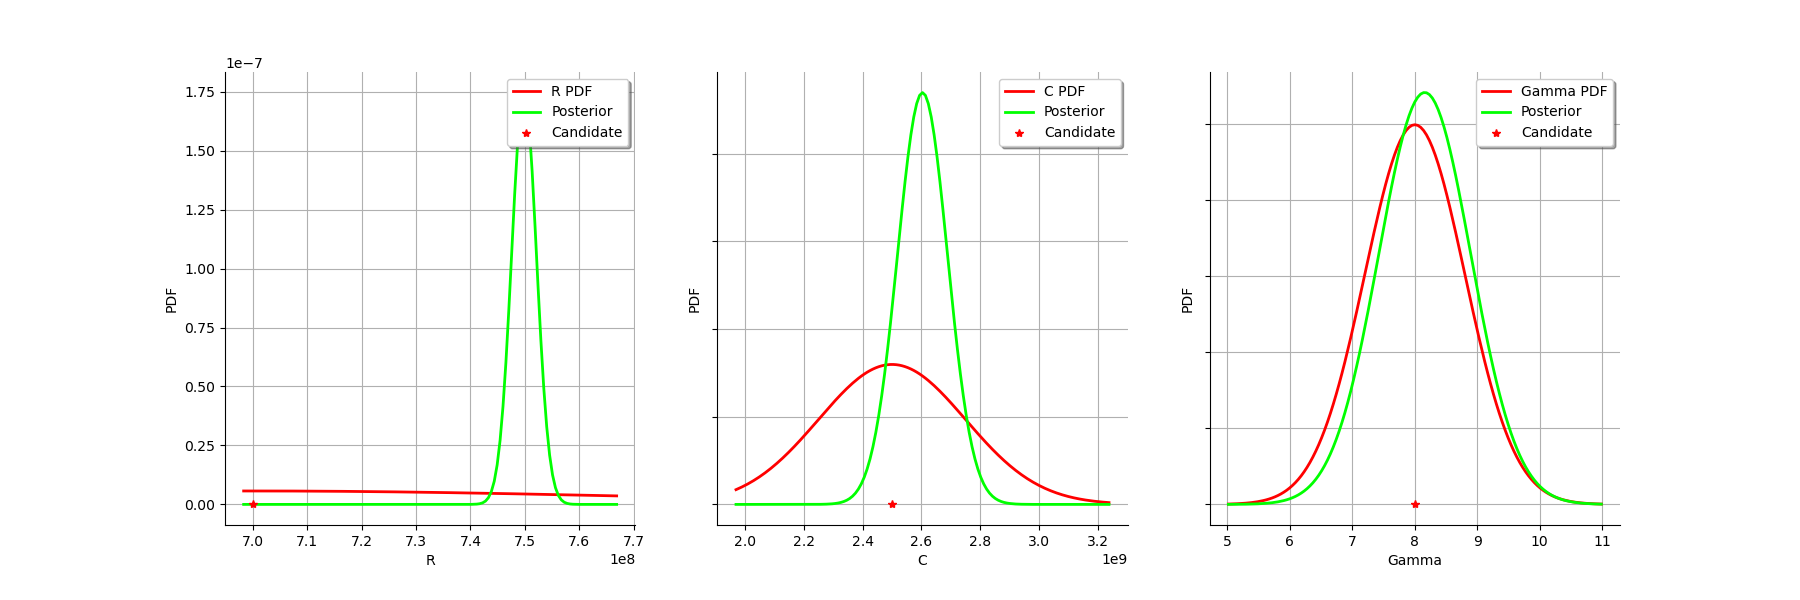

In [26]:
calibrationResult.drawParameterDistributions()

The figure on the left presents the distribution of the $R$ variable. The red curve is the prior, which is almost flat. The green curve is the posterior distribution of $R$, which is spiky and centered on $R=749.9\times 10^8$. Since the prior and posterior distributions are very different for the $R$ parameter, this implies that the observations have more weight on this parameter than the prior distibution. 

On the right plot, we see that the prior and posterior distribution are close to each other for the $\gamma$ variable: the observations did not convey much information for this variable and the prior distribution $\gamma$ has more weight.

The center plot for the $C$ parameter is intermediate: the observations have decreased the variance of the estimation, but it remains relatively close to the prior. 

## Gaussian nonlinear calibration

The `GaussianNonLinearCalibration` class performs the gaussian nonlinear calibration.

In [27]:
algo = ot.GaussianNonLinearCalibration(
    mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
)

The `run` method computes the solution of the problem.

In [28]:
algo.run()

In [29]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [30]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.50235e+08,2.58913e+09,8.07577]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [31]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.43986e+08,2.41193e+09,7.60223] upper bound=class=Point name=Unnamed dimension=3 values=[7.56916e+08,2.76289e+09,8.61261] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

As before, we can see that the $R$ parameter (the first one) has a relalively small confidence interval. The $\gamma$ parameter (the third one) is estimated with a large confidence interval, but smaller than in the linear case.

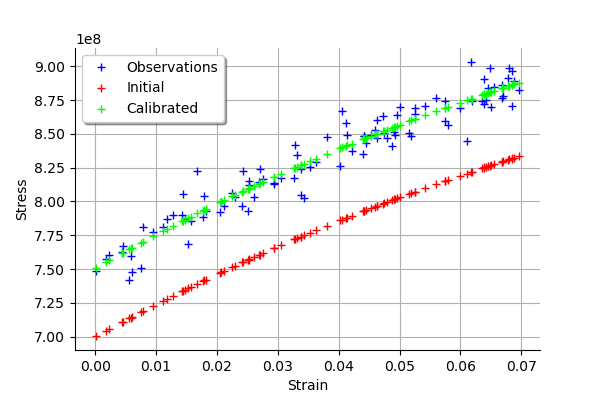

In [32]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

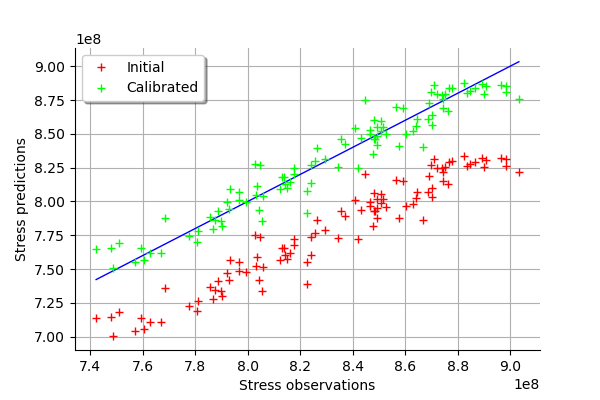

In [33]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by bootstraping the problem at the posterior. 

In [34]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[-28462.7] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

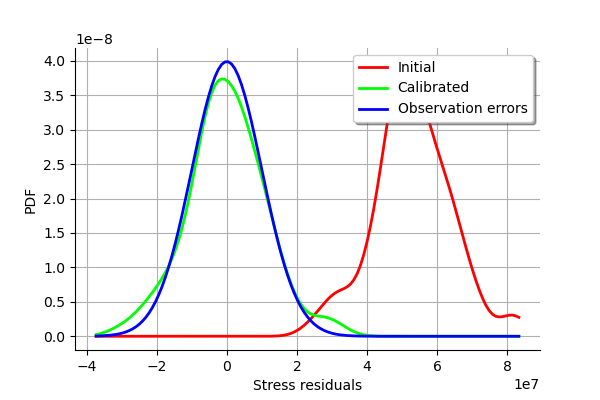

In [35]:
calibrationResult.drawResiduals()

The analysis of the distribution of the residuals (the blue line) shows that the distribution is approximately centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being gaussian.

The prior observation error distribution (in green) is much narrower than the actual residuals distribution. This shows that the prior observation error distribution underestimated the actual errors.

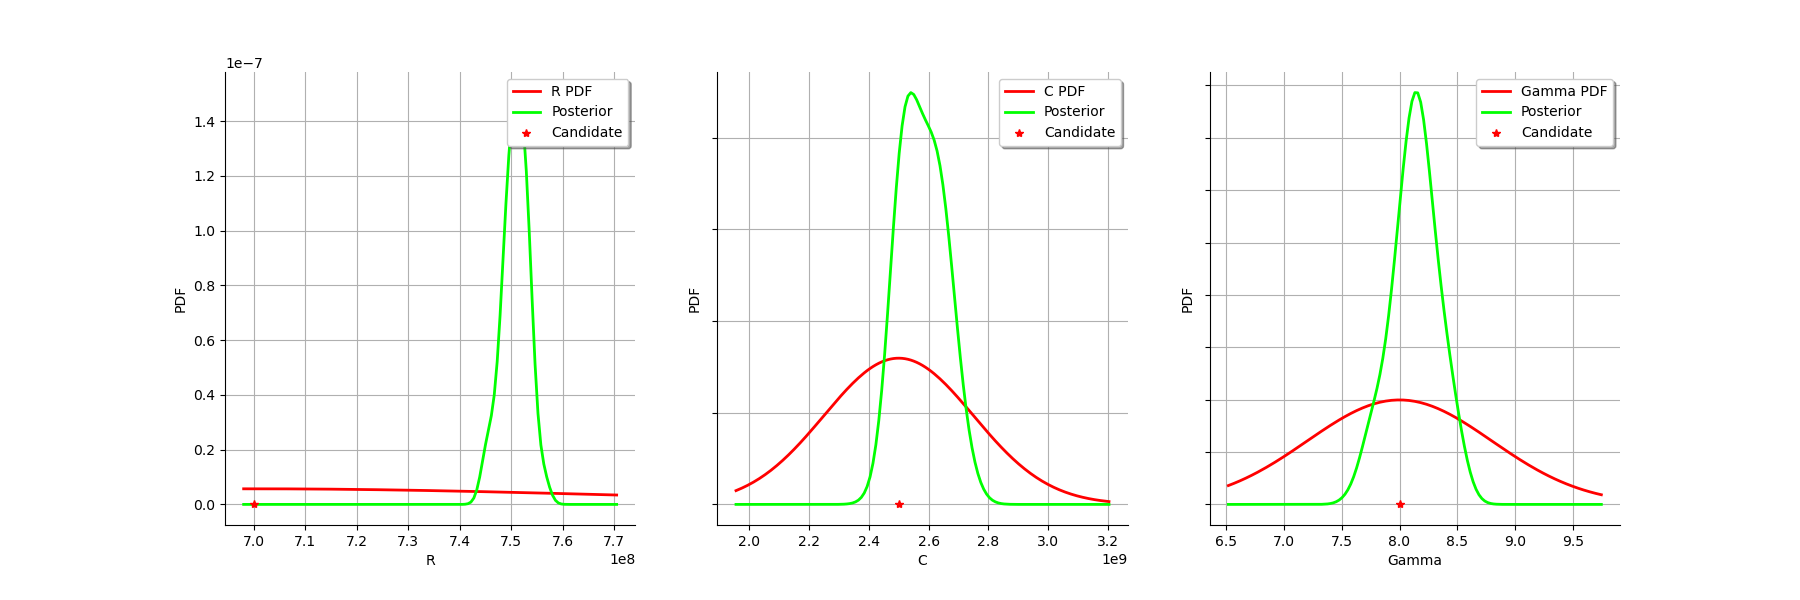

In [36]:
calibrationResult.drawParameterDistributions()

We see that the prior and posterior distribution are close to each other, but not superimposed: the observations significantly brought information during the calibration.

## Exercice 1 : changement du paramètre de référence

* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [37]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien linéaire ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien non-linéaire ? Pouvez-vous expliquer les causes de ces différences ?

## Solution de l'exercice 1 : changement du paramètre de référence

In [38]:
def calageChabocheParGaussienLineaire(thetaPrior, sigma, errorCovariance):
    """Calage du modèle de Chaboche par méthode bayésienne gaussienne  
    linéaire. 

    Arguments:
        thetaPrior : la valeur de référence
    Retourne
        thetaMAP : l'estimateur MAP
    """
    algo = ot.GaussianLinearCalibration(
        mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
    )
    algo.run()
    calibrationResult = algo.getResult()
    thetaMAP = calibrationResult.getParameterMAP()
    print("GaussianLinearCalibration")
    print("Prior:")
    print("    R_prior=%.1f (MPa)" % (thetaPrior[0] / 1.0e6))
    print("    C_prior=%.0f (MPa)" % (thetaPrior[1] / 1.0e6))
    print("    Gamma_prior=%.3f" % (thetaPrior[2]))
    print("Posterior:")
    print("    R_hat=%.1f (MPa)" % (thetaMAP[0] / 1.0e6))
    print("    C_hat=%.0f (MPa)" % (thetaMAP[1] / 1.0e6))
    print("    Gamma_hat=%.3f" % (thetaMAP[2]))
    return thetaMAP

In [39]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

sigmaStress = 1.0e7  # (Pa)

errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = sigmaStress ** 2

sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = sigmaR ** 2
sigma[1, 1] = sigmaC ** 2
sigma[2, 2] = sigmaGamma ** 2

thetaMAP1 = calageChabocheParGaussienLineaire(thetaPrior, sigma, errorCovariance)

GaussianLinearCalibration
Prior:
    R_prior=700.0 (MPa)
    C_prior=2500 (MPa)
    Gamma_prior=8.000
Posterior:
    R_hat=749.8 (MPa)
    C_hat=2604 (MPa)
    Gamma_hat=8.158


In [40]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])
thetaMAP2 = calageChabocheParGaussienLineaire(thetaPrior, sigma, errorCovariance)

GaussianLinearCalibration
Prior:
    R_prior=650.0 (MPa)
    C_prior=2300 (MPa)
    Gamma_prior=6.000
Posterior:
    R_hat=752.4 (MPa)
    C_hat=2408 (MPa)
    Gamma_hat=6.099


On observe :

* un petit écart entre $\hat{R}$ et $R_{vrai}$,
* un écart moyen entre $\hat{C}$ et $C_{vrai}$ d'une part et $\hat{\gamma}$ et $\gamma_{vrai}$ d'autre part.

La cause de ces différences est due aux facteurs suivants.

* Dans le contexte bayésien, la valeur de référence est la moyenne du vecteur gaussien à priori $\boldsymbol{\mu}$. Ainsi, lorsqu'on change $\boldsymbol{\mu}$, la solution optimale change également. On observe que la solution optimale ne s'éloigne pas beaucoup de la solution de référence `thetaPrior`. En effet, la méthode bayésienne est comme un ressort dont les deux points d'ancrage sont d'une part le vecteur à priori $\boldsymbol{\mu}$ et d'autre part les observations. 
* Le modèle est linéarisé au voisinage du point `thetaPrior`, en évaluant la Jacobienne de la fonction $h$ en ce point. Puisque la matrice Jacobienne est modifiée, la solution du problème est également différente. 

Dans le cas particulier du modèle de Chaboche, l'analyse est la suivante.

* Dans le second cas, on observe que la valeur à priori $\mu_\gamma=6$ a beaucoup d'influence sur l'estimation à posteriori $\hat{\gamma}=6.099$, alors que la valeur "vraie" est égale à 10. Pour le paramètre Gamma, c'est la valeur à priori qui "pèse". 
* Toujours dans le second cas, on observe que la valeur à priori $\mu_R=650\times 10^6$ a peu d'influence sur l'estimation à posteriori $\hat{R}=752.4\times 10^6$, alors que la valeur "vraie" est égale à $750\times 10^6$. Pour le paramètre $R$, ce sont les observations qui "pèsent". 

In [41]:
def calageChabocheParGaussienNonLineaire(thetaPrior, sigma, errorCovariance):
    """Calage du modèle de Chaboche par méthode bayésienne gaussienne  
    non linéaire. 

    Arguments:
        thetaPrior : la valeur de référence
    Retourne
        thetaMAP : l'estimateur MAP
    """
    algo = ot.GaussianNonLinearCalibration(
        mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
    )
    algo.run()
    calibrationResult = algo.getResult()
    thetaMAP = calibrationResult.getParameterMAP()
    print("GaussianNonLinearCalibration")
    print("Prior:")
    print("    R_prior=%.1f (MPa)" % (thetaPrior[0] / 1.0e6))
    print("    C_prior=%.0f (MPa)" % (thetaPrior[1] / 1.0e6))
    print("    Gamma_prior=%.3f" % (thetaPrior[2]))
    print("Posterior:")
    print("    R_hat = %.1f (MPa)" % (thetaMAP[0] / 1.0e6))
    print("    C_hat = %.0f (MPa)" % (thetaMAP[1] / 1.0e6))
    print("    Gamma_hat = %.3f" % (thetaMAP[2]))
    return thetaMAP

In [42]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

thetaMAP1 = calageChabocheParGaussienNonLineaire(thetaPrior, sigma, errorCovariance)

GaussianNonLinearCalibration
Prior:
    R_prior=700.0 (MPa)
    C_prior=2500 (MPa)
    Gamma_prior=8.000
Posterior:
    R_hat = 750.2 (MPa)
    C_hat = 2589 (MPa)
    Gamma_hat = 8.076


In [43]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])
thetaMAP2 = calageChabocheParGaussienNonLineaire(thetaPrior, sigma, errorCovariance)

GaussianNonLinearCalibration
Prior:
    R_prior=650.0 (MPa)
    C_prior=2300 (MPa)
    Gamma_prior=6.000
Posterior:
    R_hat = 752.4 (MPa)
    C_hat = 2414 (MPa)
    Gamma_hat = 6.129


L'analyse est très proche de celle du modèle linéaire. 

## Exercice 2 : changement de la matrice de covariance à priori

Dans cette question, on considère la méthode de calage gaussien linéaire.

* Dans cette question, on utilise les valeurs suivantes du paramètre `thetaPrior` :

In [44]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

* Changer le paramètre `sigma` et utiliser les valeurs numériques suivantes :

In [45]:
def computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma):
    sigma = ot.CovarianceMatrix(3)
    sigma[0, 0] = sigmaR ** 2
    sigma[1, 1] = sigmaC ** 2
    sigma[2, 2] = sigmaGamma ** 2
    return sigma

In [46]:
coefficientOfVariation = 0.5
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

sigma = computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma)

* Dessiner la loi à posteriori. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?
* Changer le paramètre `sigma` et utiliser les valeurs numériques suivantes :

In [47]:
coefficientOfVariation = 0.01
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

sigma = computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma)

* Dessiner la loi à posteriori. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?

## Solution de l'exercice 2 : changement de la matrice de covariance à priori


In [48]:
def calageChabocheParGaussienLineairePlot(thetaPrior, sigma, errorCovariance):
    """Calage du modèle de Chaboche par méthode bayésienne gaussienne  
    linéaire. 

    Arguments:
        thetaPrior : la valeur de référence
    Retourne
        thetaMAP : l'estimateur MAP
    """
    algo = ot.GaussianLinearCalibration(
        mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
    )
    algo.run()
    calibrationResult = algo.getResult()
    thetaMAP = calibrationResult.getParameterMAP()
    print("GaussianLinearCalibration")
    print("R* = %.1f (MPa)" % (thetaMAP[0] / 1.0e6))
    print("C* = %.0f (MPa)" % (thetaMAP[1] / 1.0e6))
    print("Gamma* = %.3f" % (thetaMAP[2]))
    graph = calibrationResult.drawParameterDistributions()
    otv.View(graph)
    return thetaMAP

In [49]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

GaussianLinearCalibration
R* = 748.4 (MPa)
C* = 2734 (MPa)
Gamma* = 9.664


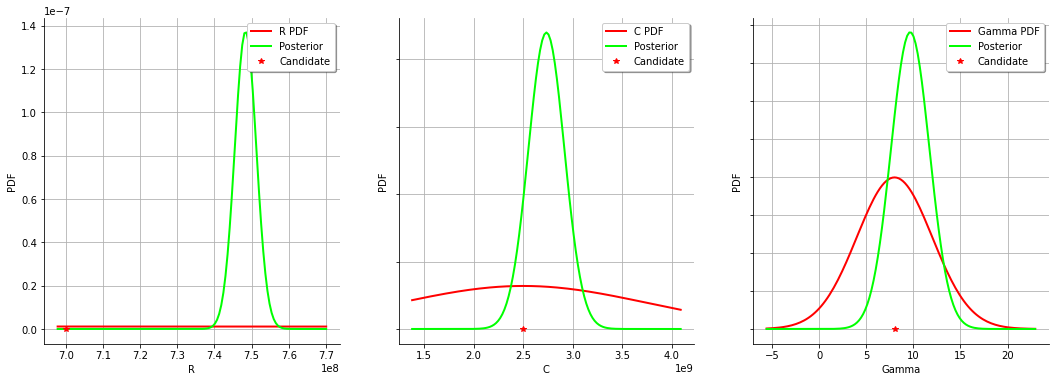

In [50]:
coefficientOfVariation = 0.5
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

sigma = computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma)
thetaMAP1 = calageChabocheParGaussienLineairePlot(thetaPrior, sigma, errorCovariance)

GaussianLinearCalibration
R* = 750.8 (MPa)
C* = 2530 (MPa)
Gamma* = 7.983


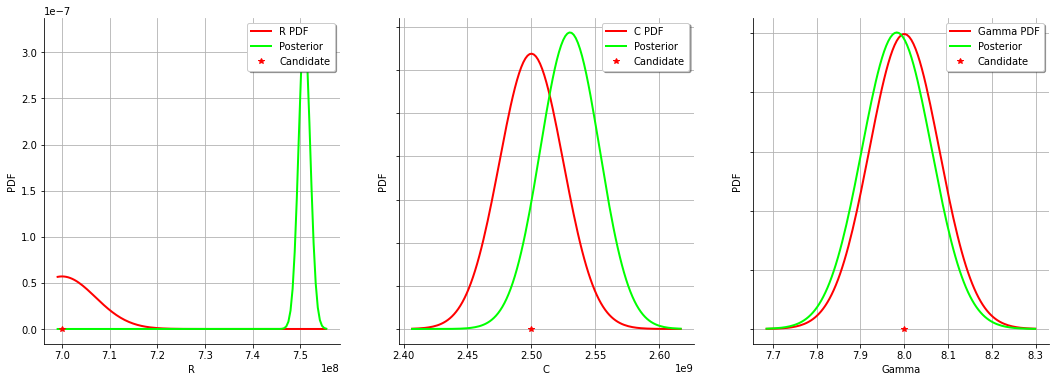

In [51]:
coefficientOfVariation = 0.01
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

sigma = computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma)
thetaMAP1 = calageChabocheParGaussienLineairePlot(thetaPrior, sigma, errorCovariance)

En général, diminuer la valeur du paramètre `coefficientOfVariation` revient à affecter plus de poids à l'*a priori*. En effet, la matrice de covariance $B$ est alors plus proche de zéro, donc son inverse $B^{-1}$ est plus grand. Dans la fonction coût associée au calage bayésien, la loi *a priori* pèse davantage. 

Dans le cas du modèle de Chaboche, on observe que lorsque `coefficientOfVariation=0.01`, la loi *a priori* sur $R$ est plus étroite. Cela n'a pas beaucoup d'effet sur l'estimation $\hat{R}$, qui reste proche de $R_{vrai}$. Par contre, les lois *a posteriori* des paramètres $\hat{C}$ et $\hat{\gamma}$ sont encore plus proches de leurs lois *a priori*. 

## Exercice 3 : changement de la covariance du bruit d'observation

* Définir les valeurs suivantes du bruit d'observation.

In [52]:
sigmaStress = 1.0e7  # (Pa) Valeur de référence

In [53]:
sigmaStress = 10.0e7  # (Pa) Nouvelle valeur 1

In [54]:
sigmaStress = 100.0e7  # (Pa) Nouvelle valeur 2

* Pour le calage gaussien linéaire, dessiner les lois à priori et à posteriori. 
* Quels sont les changements ? Pouvez-vous expliquer ces changements ?

## Solution de l'exercice 3 : changement de la covariance du bruit d'observation

GaussianLinearCalibration
R* = 749.8 (MPa)
C* = 2604 (MPa)
Gamma* = 8.158
GaussianLinearCalibration
R* = 750.8 (MPa)
C* = 2530 (MPa)
Gamma* = 7.983
GaussianLinearCalibration
R* = 717.3 (MPa)
C* = 2507 (MPa)
Gamma* = 7.996


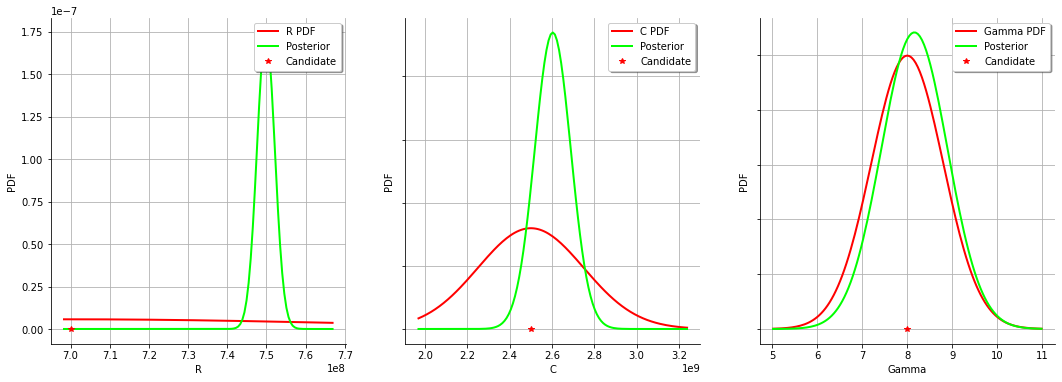

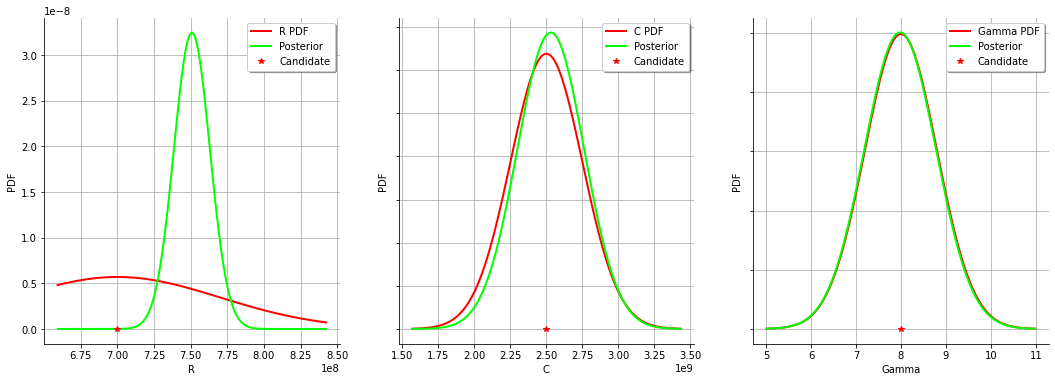

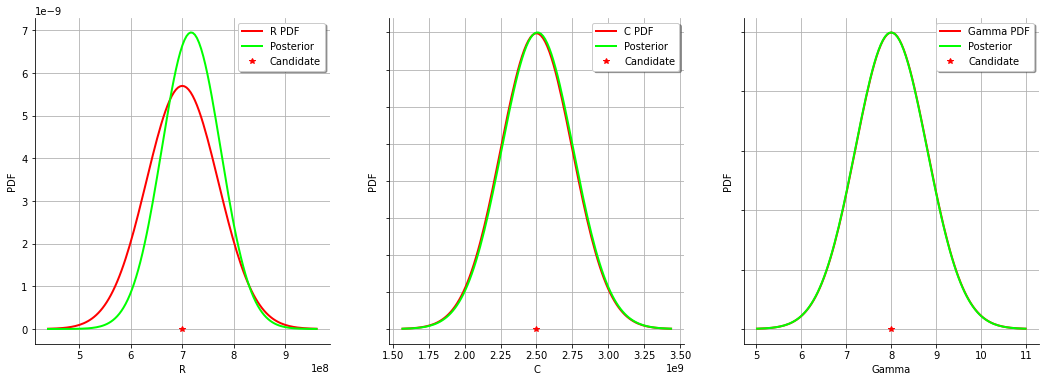

In [55]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

coefficientOfVariation = 0.1
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

sigma = computePriorCovarianceMatrix(sigmaR, sigmaC, sigmaGamma)

for sigmaStress in [1.0e7, 10.0e7, 100.0e7]:
    errorCovariance = ot.CovarianceMatrix(1)
    errorCovariance[0, 0] = sigmaStress ** 2
    thetaMAP = calageChabocheParGaussienLineairePlot(thetaPrior, sigma, errorCovariance)

On observe que lorsque le bruit d'observation augmente, la loi à posteriori est de plus en plus proche de la loi à priori. 